In [10]:
import arviz as az
import numpy as np
import os.path as op
import pandas as pd

import seaborn as sns
from bauer.utils.plotting import plot_prediction
import matplotlib.pyplot as plt
from tms_risk.cogmodels.fit_model import build_model, get_data
from bauer.utils.math import softplus_np

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)


def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

def get_ppc(model, idata, df):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

    return ppc

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

bids_folder = '/data/ds-tmsrisk'

In [2]:
def get_pars(idata, group=True):
    traces = {}

    pars_vertex = []
    pars_ips = []

    keys = ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

    for key in keys:

        if group:
            key_ = key+'_mu'
        else:
            key_ = key
        
        if key_ in idata.posterior.keys():
            print(key_)

            traces[key] = idata.posterior[f'{key_}'].to_dataframe()

            ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')


            if 'stimulation_condition[T.vertex]' in traces[key].index.get_level_values(f'{key}_regressors'):
                vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
            else:
                vertex_values = ips_values

            if (key in ['n1_evidence_sd', 'n2_evidence_sd']) and 'evidence_sd' in idata.posterior.keys():
                if group:
                    key__ = 'evidence_sd_mu'
                else:
                    key__ = 'evidence_sd'
                
                print('yo')
                ips_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[ips]', 0, f'evidence_sd_regressors').values
                vertex_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[vertex]', 0, f'evidence_sd_regressors').values


            if key in ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
                ips_values = softplus_np(ips_values)
                vertex_values = softplus_np(vertex_values)

            pars_ips.append(ips_values)
            pars_vertex.append(vertex_values)


    pars_ips = pd.concat(pars_ips, axis=1)
    pars_vertex = pd.concat(pars_vertex, axis=1)

    pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
    pars.columns.name = 'parameter'
    pars = pars.stack().to_frame('value')

    return pars


def plot_pars(pars, df, ):
    g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

    g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
    g.set_titles('{col_name}')


    g.axes.flat[0].axhline(df['n_risky'].mean(), color='k', linestyle='--')
    g.axes.flat[1].axhline(df['n_risky'].std(), color='k', linestyle='--')
    g.axes.flat[2].axhline(df['n_safe'].mean(), color='k', linestyle='--')
    g.axes.flat[3].axhline(df['n_safe'].std(), color='k', linestyle='--')

    return g


In [26]:
df = get_data(model_label='flexible1')
model = build_model(df=df, model_label='flexible1')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible1_trace.netcdf'))

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [45]:
n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1880/742141065.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1880/742141065.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1880/742141065.py:2: FutureWarning: In a future version of pandas all arguments of concat except 

In [46]:
x = np.linspace(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(5)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

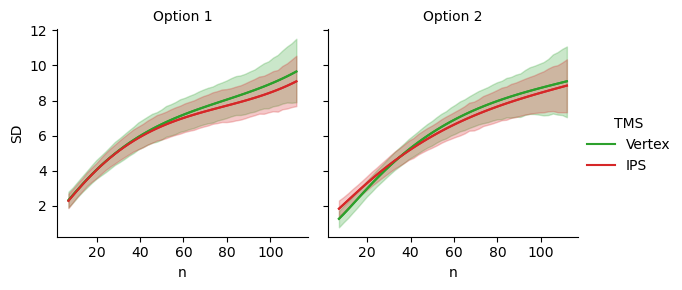

In [47]:
g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_evidence_sd.pdf'))

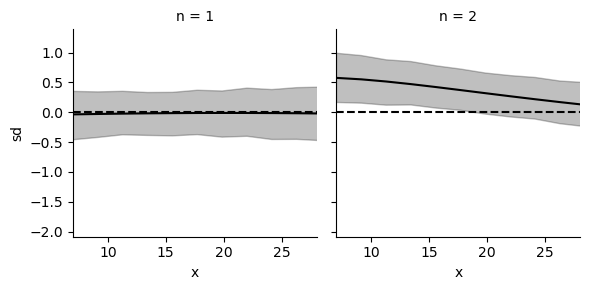

In [67]:
tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 28)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_evidence_sd_diff.pdf'))

<Axes: xlabel='x', ylabel='diff'>

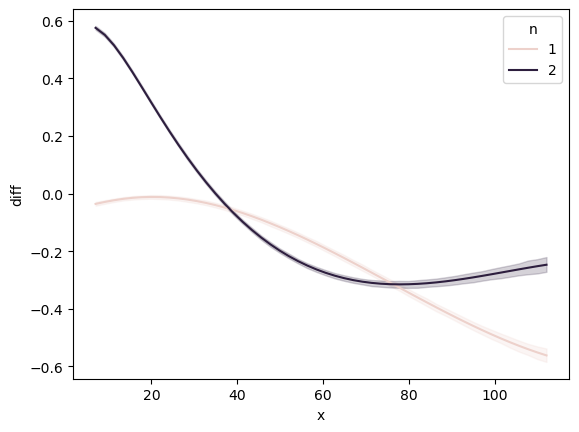

In [51]:
sns.lineplot(x='x', y='diff', hue='n', data=diff.to_frame('diff').reset_index())

In [49]:
diff.groupby(['n', 'x']).apply(lambda x: (x>0).mean())

n  x         
1  7.000000      0.42875
   9.142857      0.43875
   11.285714     0.45100
   13.428571     0.46200
   15.571429     0.47450
                  ...   
2  103.428571    0.33900
   105.571429    0.35250
   107.714286    0.36425
   109.857143    0.37850
   112.000000    0.39175
Length: 100, dtype: float64

risky_prior_mu_mu
risky_prior_std_mu
safe_prior_mu_mu
safe_prior_std_mu


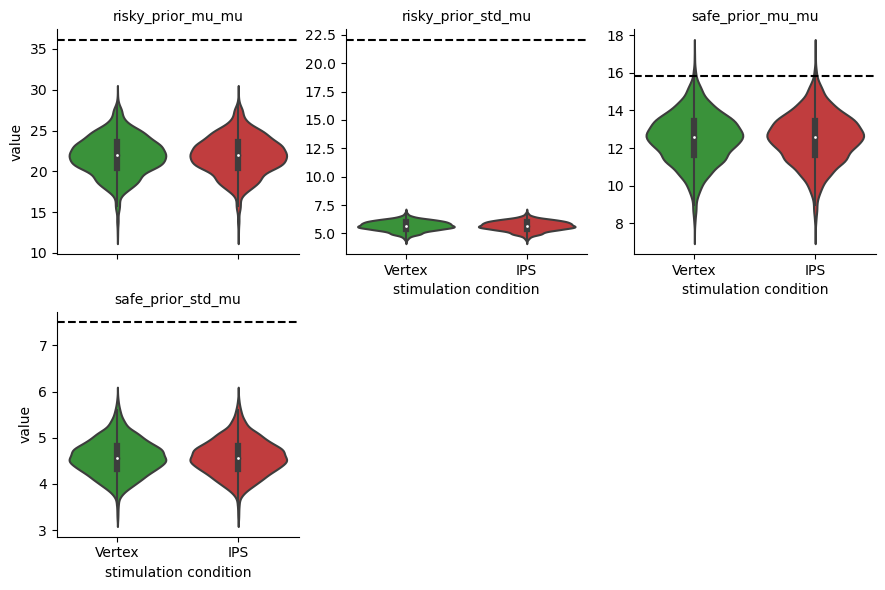

In [38]:
pars = get_pars(idata)
g = plot_pars(pars, df)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_pars.pdf'))

In [34]:
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

Sampling: [ll_bernoulli]


In [35]:
from tms_risk.cogmodels.utils import plot_ppc

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

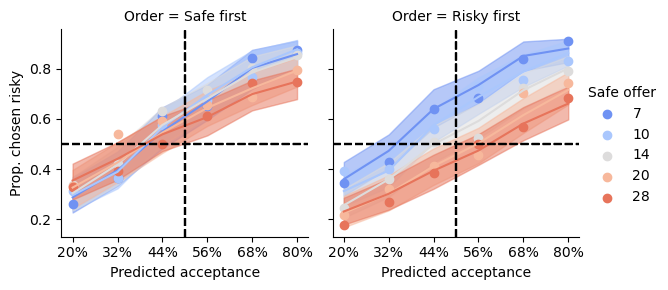

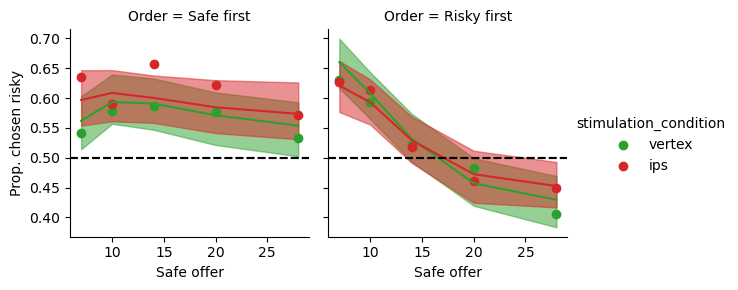

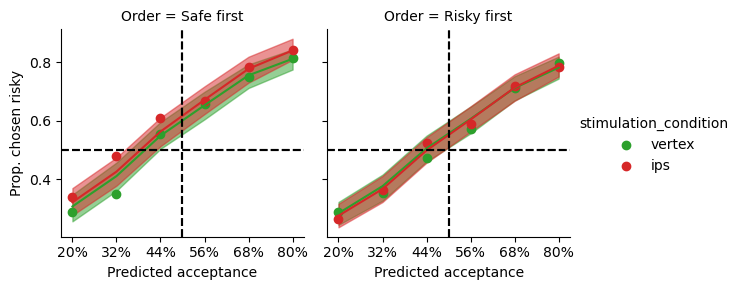

In [37]:
for plot_type in [5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')

    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_ppc{plot_type}.pdf'))

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


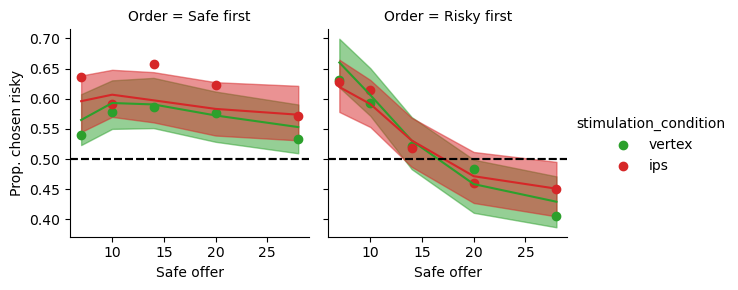

In [12]:
plot_ppc(df, ppc, plot_type=6, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


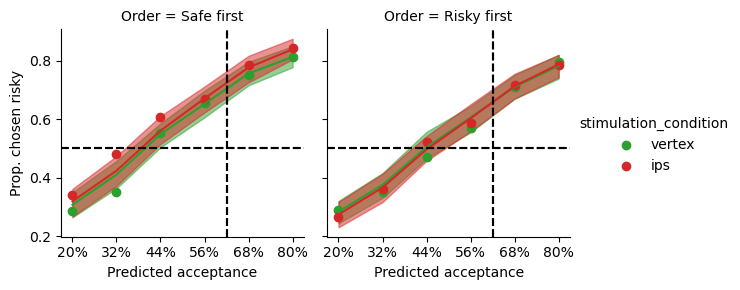

In [13]:
plot_ppc(df, ppc, plot_type=7, level='group')

# Flexible 1 null

In [3]:
df = get_data(model_label='flexible1_null')
model = build_model(df=df, model_label='flexible1_null')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible1_null_trace.netcdf'))

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [5]:
x = np.linspace(7, 112)
dm = model.make_dm(x)

n1_evidence_sd = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n2_evidence_sd = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)


def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd, n2_evidence_sd]:
    d.columns = range(5)

evidence_sd = pd.concat((n1_evidence_sd, n2_evidence_sd, ),axis=0,
                        keys=[1, 2], names=['n'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n'], group_keys=True).apply(get_curve_stats)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_18787/723571541.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_18787/723571541.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n2_evidence_sd = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)


In [8]:
curve_stats

sd    hdi025     hdi975
n x                                        
1 7.000000    2.313279  1.979652   2.637260
  9.142857    2.604458  2.271411   2.898636
  11.285714   2.889092  2.576950   3.200345
  13.428571   3.165152  2.823686   3.479391
  15.571429   3.431383  3.064730   3.773868
...                ...       ...        ...
2 103.428571  8.464336  7.349208   9.695521
  105.571429  8.539600  7.357542   9.766405
  107.714286  8.614396  7.394601   9.895516
  109.857143  8.688914  7.452399  10.057317
  112.000000  8.763344  7.400550  10.112012

[100 rows x 3 columns]

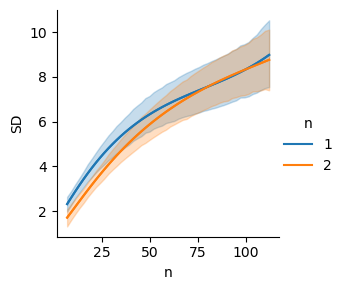

In [9]:
g = sns.FacetGrid(curve_stats.reset_index(), hue='n')
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_null_evidence_sd.pdf'))

# Flexible 2

In [11]:
df = get_data(model_label='flexible2')
model = build_model(df=df, model_label='flexible2')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible2_trace.netcdf'))


/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [12]:
perceptual_noise_sd_ips = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
perceptual_noise_sd_vertex = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

memory_noise_sd_ips = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
memory_noise_sd_vertex = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1880/624700234.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  perceptual_noise_sd_ips = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1880/624700234.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  perceptual_noise_sd_vertex = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1880/624700234.py:2: FutureWarning: In a future version of pandas all ar

In [13]:
for d in [perceptual_noise_sd_ips, perceptual_noise_sd_vertex, memory_noise_sd_ips, memory_noise_sd_vertex]:
    d.columns = range(5)

evidence_sd = pd.concat([perceptual_noise_sd_ips, perceptual_noise_sd_vertex, memory_noise_sd_ips, memory_noise_sd_vertex], axis=0,
                        keys=[('perceptual', 'IPS'), ('perceptual', 'Vertex'), ('memory', 'IPS'), ('memory', 'Vertex')], names=['noise', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['noise', 'TMS'], group_keys=True).apply(get_curve_stats)

(0.0, 10.0)

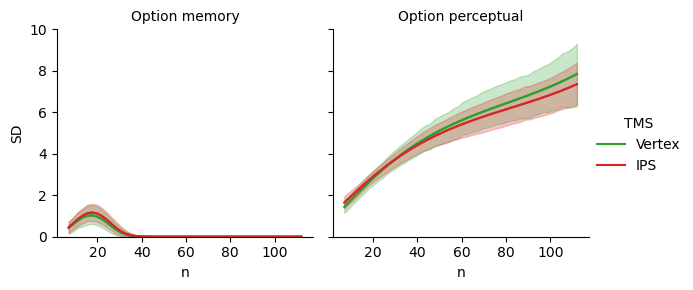

In [14]:
g = sns.FacetGrid(curve_stats.reset_index(), col='noise', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()
plt.ylim(0, 10)

# g.savefig(op.join(target_dir, f'model{model_label}_evidence_sd.pdf'))

(7.0, 28.0)

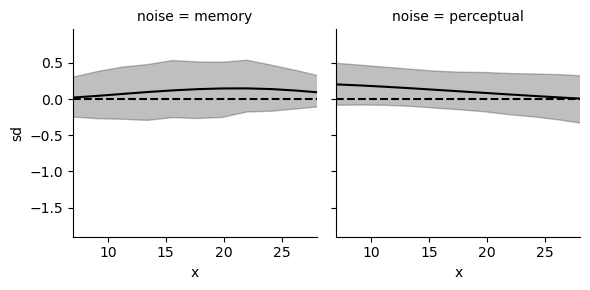

In [18]:
tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby=['noise'])

g = sns.FacetGrid(diff_stats.reset_index(), col='noise')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 28)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (57), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'risky_prior_mu_mu'}>,
        <Axes: title={'center': 'risky_prior_mu_mu'}>],
       [<Axes: title={'center': 'risky_prior_mu_offset'}>,
        <Axes: title={'center': 'risky_prior_mu_offset'}>],
       [<Axes: title={'center': 'risky_prior_std_mu'}>,
        <Axes: title={'center': 'risky_prior_std_mu'}>],
       [<Axes: title={'center': 'risky_prior_std_offset'}>,
        <Axes: title={'center': 'risky_prior_std_offset'}>],
       [<Axes: title={'center': 'safe_prior_mu_mu'}>,
        <Axes: title={'center': 'safe_prior_mu_mu'}>],
       [<Axes: title={'center': 'safe_prior_mu_offset'}>,
        <Axes: title={'center': 'safe_prior_mu_offset'}>],
       [<Axes: title={'center': 'safe_prior_std_mu'}>,
        <Axes: title={'center': 'safe_prior_std_mu'}>],
       [<Axes: title={'center': 'safe_prior_std_offset'}>,
        <Axes: title={'center': 'safe_prior_std_offset'}>],
       [<Axes: title={'center': 'perceptual_noise_sd_poly0_mu'}>,
        <Axes:

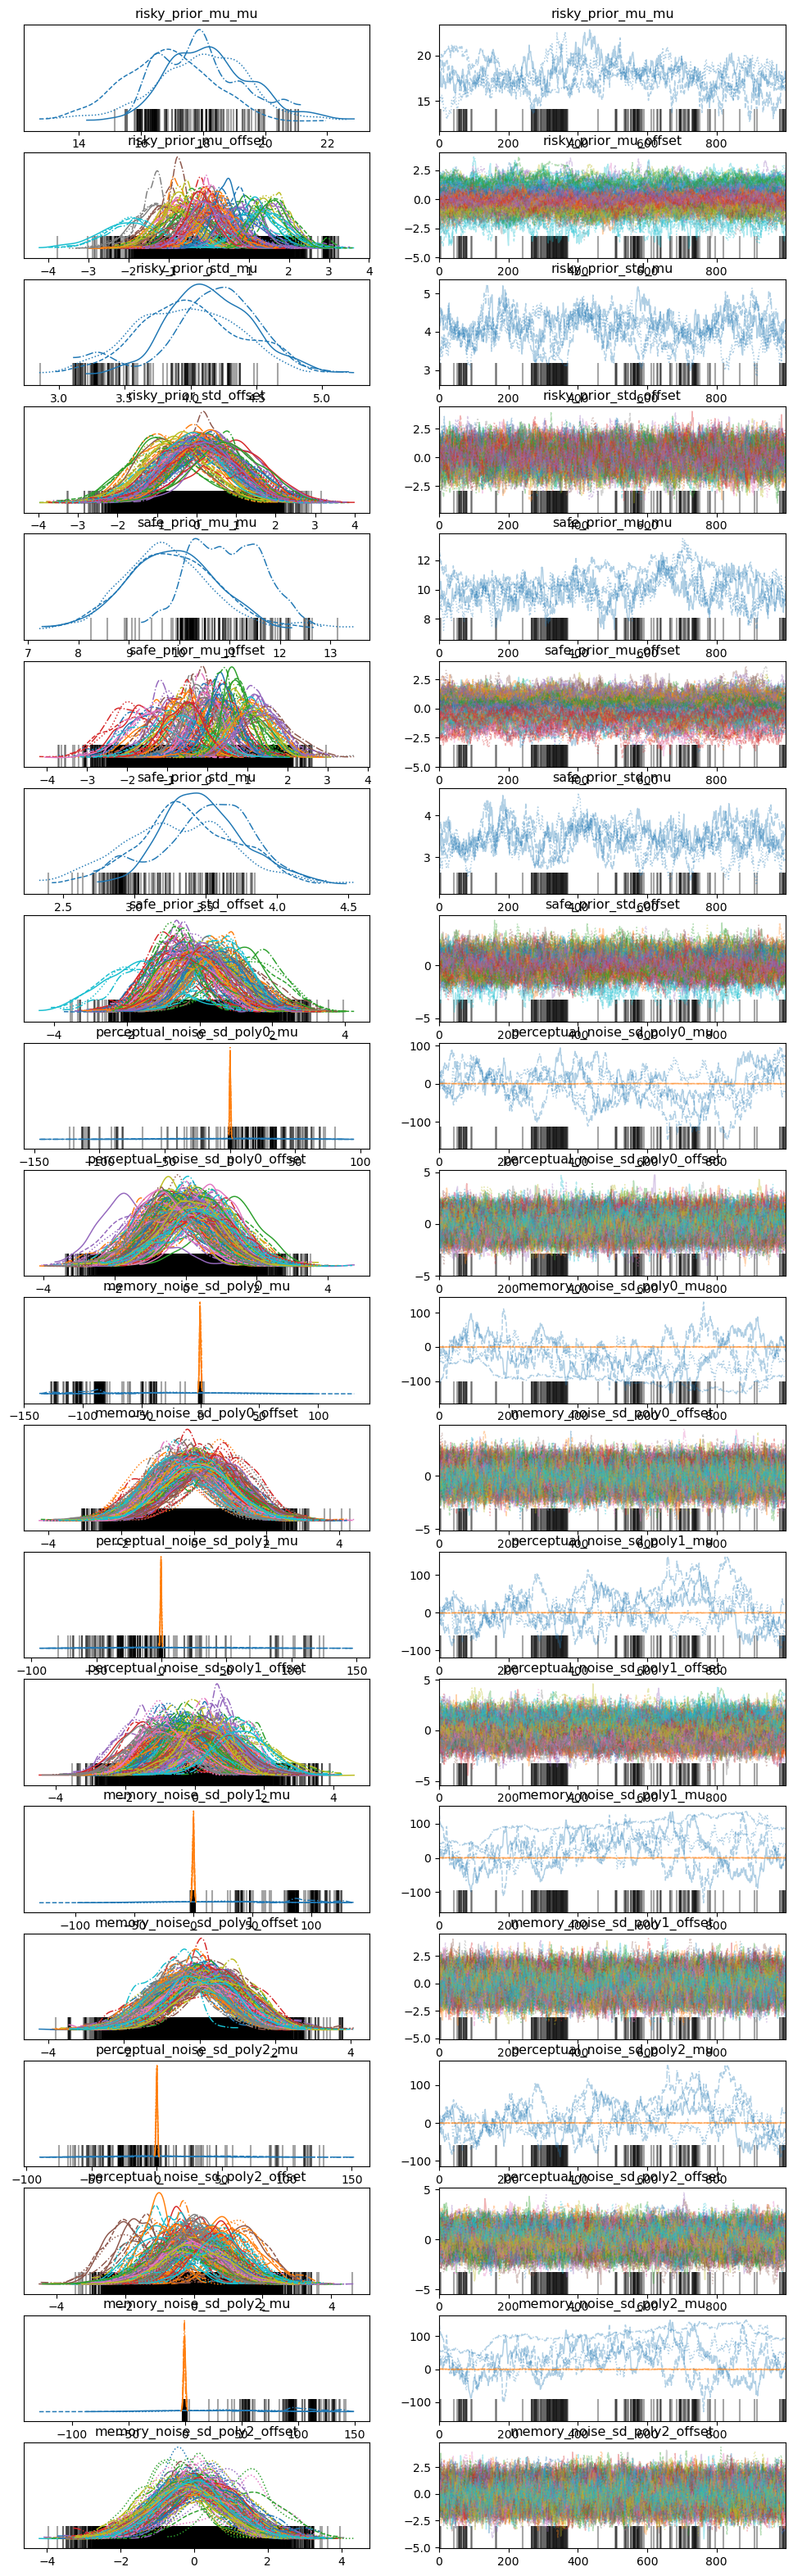

In [20]:
az.plot_trace(idata)